In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from scipy.stats import ks_2samp, mannwhitneyu, norm
import scipy.stats as stats
from collections import Counter

In [88]:
from scipy.stats import ks_2samp, mannwhitneyu, norm
import scipy.stats as stats
from collections import Counter

In [4]:
dm = pd.read_csv("gecko_pelts.csv", index_col = 0)

In [5]:
len(dm)

1077

In [51]:
def cohens_d(x, y):
    return (x.mean() - y.mean()) / np.sqrt((x.var() + y.var()) / 2)

In [74]:
folder = "first_round"
output = "combined_withword.csv"
all_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
df_list = [pd.read_csv(os.path.join(folder, file)) for file in all_files]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv(output, index=False)

In [9]:
dm['Word'] = dm['word']

In [75]:
merged_df = pd.merge(dm, combined_df, on='Word', how='left')

In [76]:
merged_df.columns

Index(['word', 'unique_threads', 'reappearance_rate', 'threadwise_density',
       'repeat_ratio', 'time_stickiness', 'time_entropy',
       'normalized_unique_threads_zscore', 'normalized_unique_threads_minmax',
       'normalized_reappearance_rate_zscore',
       'normalized_reappearance_rate_minmax',
       'normalized_threadwise_density_zscore',
       'normalized_threadwise_density_minmax',
       'normalized_repeat_ratio_zscore', 'normalized_repeat_ratio_minmax',
       'normalized_time_stickiness_zscore',
       'normalized_time_stickiness_minmax', 'normalized_time_entropy_zscore',
       'normalized_time_entropy_minmax', 'Word',
       'First_Cosine_Similarity_Mean', 'First_Cosine_Similarity_STD',
       'First_Cosine_Similarity_CI', 'First_Wasserstein_Distance_Mean',
       'First_Wasserstein_Distance_STD', 'First_Wasserstein_Distance_CI',
       'First_Entropy_Mean', 'First_Entropy_STD', 'First_Entropy_CI',
       'First_Entropy_Diff_Mean', 'First_Entropy_Diff_STD',
       'F

In [95]:
negative_entropy = merged_df[merged_df['normalized_time_entropy_zscore'] < 0]
len(negative_entropy)

97

In [96]:
positive_entropy = merged_df[merged_df['normalized_time_entropy_zscore'] > 0]
len(positive_entropy)

980

In [ ]:
def ensure_tuple(x):
    if isinstance(x, tuple):
        return x  # Already a tuple
    elif isinstance(x, float):
        return (x, x)  # Convert float to a tuple of itself
    else:
        return (np.nan, np.nan)  # Handle unexpected cases

In [83]:
# Define the metrics and their readable names
metrics = {
    'First_Cosine_Similarity_Mean': 'Cosine Similarity',
    'First_Wasserstein_Distance_Mean': 'Wasserstein Distance',
    'First_Entropy_Mean' : 'Entropy',
    'First_Rank_Stability_Mean': 'Rank Stability',
    'First_Temporal_Jaccard_Mean': 'Temporal Jaccard'
}

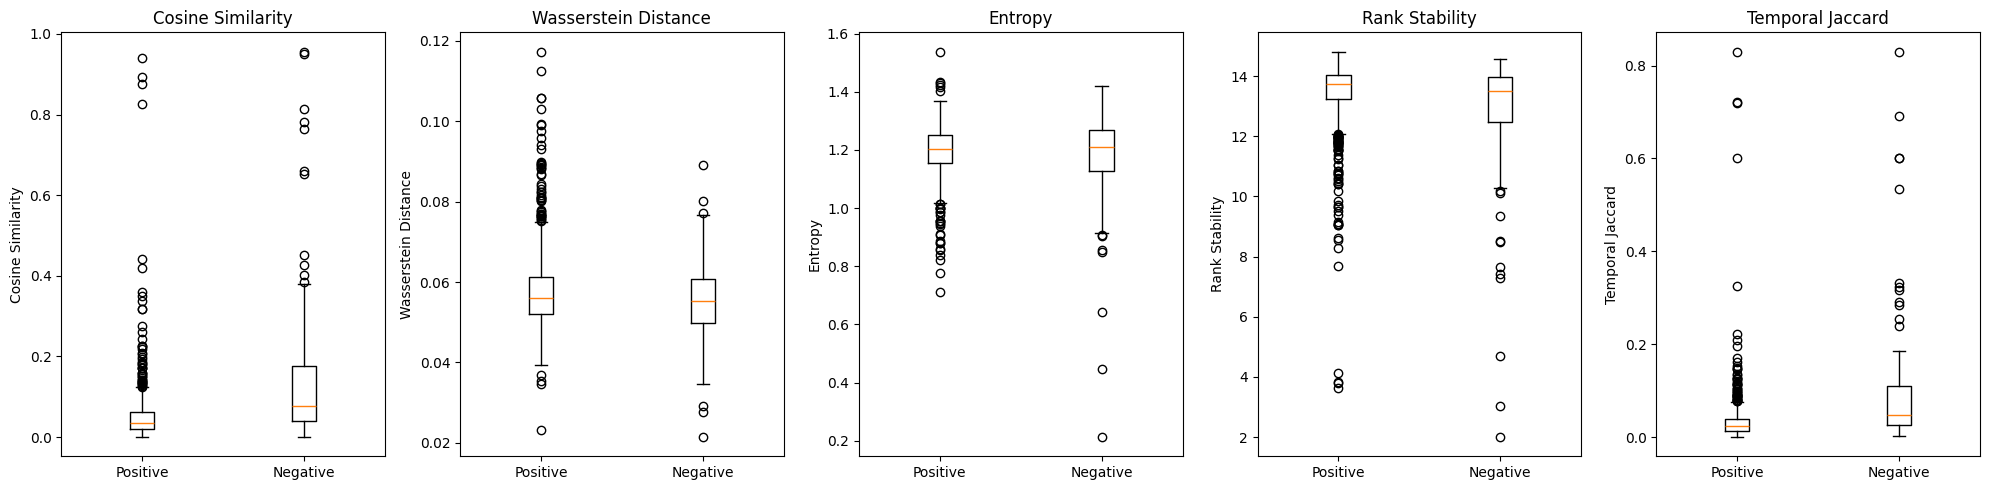

In [84]:
# Initialize dictionary to store statistical results
stats_results = {}

# Set up subplots for boxplots only
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

# Iterate through each metric
for i, (metric, readable_name) in enumerate(metrics.items()):
    # Extract values and drop NaNs
    pos_vals = positive_entropy[metric].dropna()
    neg_vals = negative_entropy[metric].dropna()

    # Compute statistical tests
    ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
    mw_stat, mw_p = mannwhitneyu(pos_vals, neg_vals, alternative='two-sided')

    # Compute Cohen's d
    def cohens_d(x, y):
        return (x.mean() - y.mean()) / np.sqrt((x.var() + y.var()) / 2)

    d = cohens_d(pos_vals, neg_vals)

    # Compute 95% Confidence Intervals
    ci_pos = norm.interval(0.95, loc=pos_vals.mean(), scale=pos_vals.std()/np.sqrt(len(pos_vals)))
    ci_neg = norm.interval(0.95, loc=neg_vals.mean(), scale=neg_vals.std()/np.sqrt(len(neg_vals)))

    # Store results
    stats_results[readable_name] = {
        'KS Test Statistic': ks_stat, 'KS Test p-value': ks_p,
        'Mann-Whitney U Statistic': mw_stat, 'Mann-Whitney p-value': mw_p,
        'Cohen’s d': d,
        '95% CI Positive': ci_pos, '95% CI Negative': ci_neg
    }

    # Boxplot
    axes[i].boxplot([pos_vals, neg_vals], tick_labels=['Positive', 'Negative'])
    axes[i].set(ylabel = readable_name, title = f'{readable_name}')
    #axes[i].set_title(f'{readable_name}')
    #axes[i].set_ylabel(readable_name)

# Adjust layout
plt.tight_layout()
plt.show()


In [85]:
# Convert results to a DataFrame and display
stats_df = pd.DataFrame(stats_results).T
stats_df

,KS Test Statistic,KS Test p-value,Mann-Whitney U Statistic,Mann-Whitney p-value,Cohen’s d,95% CI Positive,95% CI Negative
Cosine Similarity,0.371724,0.0,25599.0,0.0,-0.692994,"(0.04609396104972473, 0.0549479731533717)","(0.11725444578771418, 0.200759613337073)"
Wasserstein Distance,0.124491,0.118288,51951.0,0.125821,0.224432,"(0.057039063149063554, 0.05824667339346669)","(0.05329845231231988, 0.05746856054546313)"
Entropy,0.120405,0.141632,46347.0,0.697694,0.152003,"(1.1899137585437303, 1.2002959035184597)","(1.1381098715578717, 1.2095842255602065)"
Rank Stability,0.209576,0.000701,57795.0,0.000412,0.464836,"(13.385144893946237, 13.523691386442554)","(12.140209114555255, 13.069815460556136)"
Temporal Jaccard,0.345829,0.0,26254.0,0.0,-0.62131,"(0.030007409128853076, 0.03649758005490209)","(0.07319352986746437, 0.13302788237140387)"


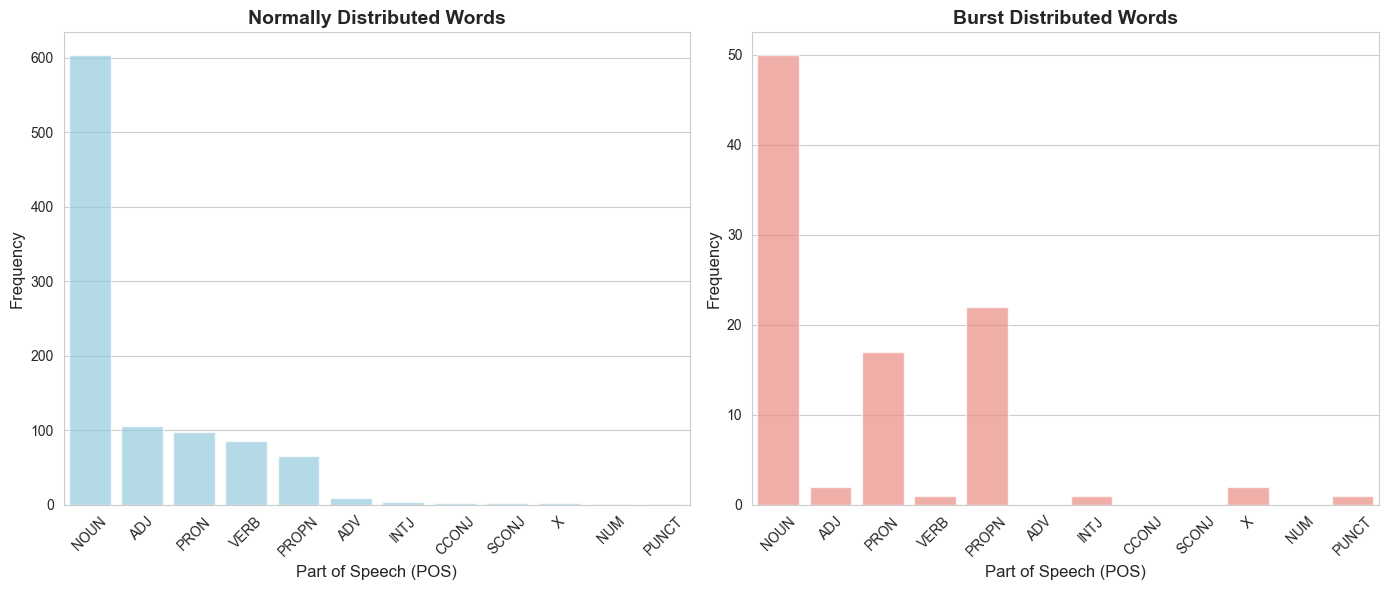

In [134]:
positive_pos = positive_entropy['First_Most_Common_POS'].dropna()
negative_pos = negative_entropy['First_Most_Common_POS'].dropna()
positive_pos_counts = positive_pos.value_counts()
negative_pos_counts = negative_pos.value_counts()

ordered_pos_tags = positive_pos_counts.index.tolist()  # Order by positive words frequency
# Create figure with two separate histograms (no shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram for positive entropy words
sns.barplot(x=positive_pos_counts.index, y=positive_pos_counts.values, color='skyblue', alpha=0.7, ax=axes[0], order=ordered_pos_tags)
axes[0].set_title("Normally Distributed Words", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Part of Speech (POS)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot histogram for negative entropy words
sns.barplot(x=negative_pos_counts.index, y=negative_pos_counts.values, color='salmon', alpha=0.7, ax=axes[1], order=ordered_pos_tags)
axes[1].set_title("Burst Distributed Words", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Part of Speech (POS)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [89]:
word_list = merged_df['First_First_Guess_Guess'].dropna().astype(str).str.split().sum()
word_counts = Counter(word_list)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
word_freq_df = word_freq_df.sort_values(by='Count', ascending=False)

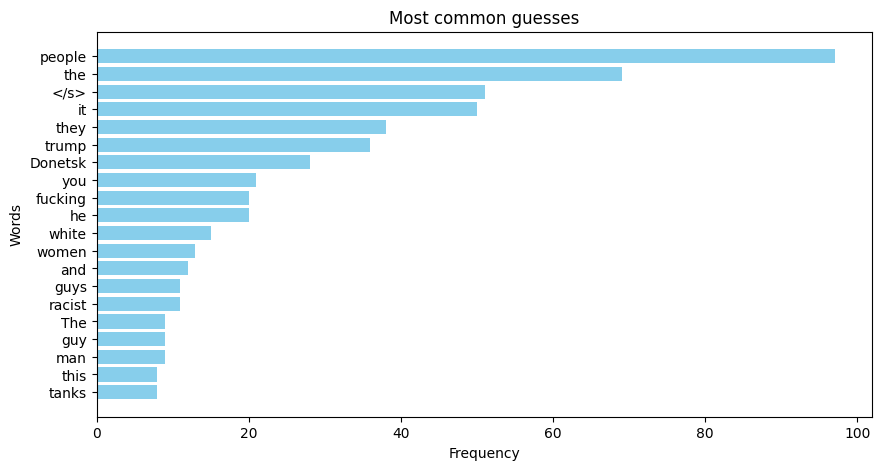

In [92]:
plt.figure(figsize=(10, 5))
plt.barh(word_freq_df['Word'][:20], word_freq_df['Count'][:20], color='skyblue')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Most common guesses')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency words at the top
plt.show()

In [93]:
merged_df['guess_rarity'] = merged_df['First_First_Guess_Guess'].map(word_counts).fillna(0).astype(int)

In [94]:
merged_df['guess_rarity_normalized'] = (merged_df['guess_rarity'] - merged_df['guess_rarity'].min()) / (merged_df['guess_rarity'].max() - merged_df['guess_rarity'].min())

/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_40893/139010578.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pos_vals, neg_vals], labels=['Positive', 'Negative'], patch_artist=True, boxprops=dict(facecolor="skyblue"))


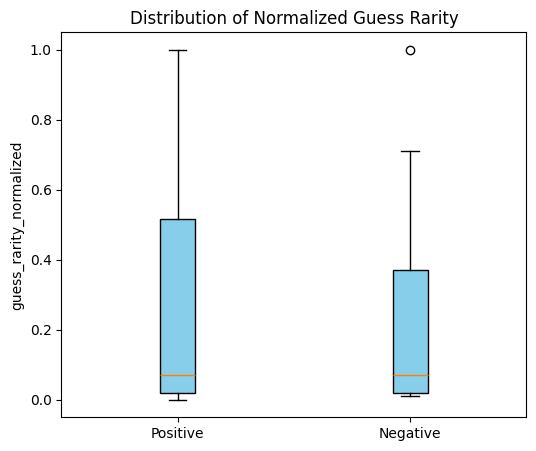

In [97]:
# Initialize dictionary to store statistical results
stats_results_guess_rarity = {}

# Extract values and drop NaNs
pos_vals = positive_entropy['guess_rarity_normalized'].dropna()
neg_vals = negative_entropy['guess_rarity_normalized'].dropna()

# Compute statistical tests
ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
mw_stat, mw_p = mannwhitneyu(pos_vals, neg_vals, alternative='two-sided')

d = cohens_d(pos_vals, neg_vals)

# Compute 95% Confidence Intervals
ci_pos = norm.interval(0.95, loc=pos_vals.mean(), scale=pos_vals.std()/np.sqrt(len(pos_vals)))
ci_neg = norm.interval(0.95, loc=neg_vals.mean(), scale=neg_vals.std()/np.sqrt(len(neg_vals)))

# Store results
stats_results_guess_rarity['guess_rarity_normalized'] = {
    'KS Test Statistic': ks_stat, 'KS Test p-value': ks_p,
    'Mann-Whitney U Statistic': mw_stat, 'Mann-Whitney p-value': mw_p,
    'Cohen’s d': d,
    '95% CI Positive': ci_pos, '95% CI Negative': ci_neg
}

# Set up figure for boxplot
plt.figure(figsize=(6, 5))
plt.boxplot([pos_vals, neg_vals], labels=['Positive', 'Negative'], patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.ylabel('guess_rarity_normalized')
plt.title('Distribution of Normalized Guess Rarity')
plt.show()

In [116]:
stats_results_guess_rarity

{'guess_rarity_normalized': {'KS Test Statistic': np.float64(0.15260887860298758),
  'KS Test p-value': np.float64(0.02907249973464483),
  'Mann-Whitney U Statistic': np.float64(50753.0),
  'Mann-Whitney p-value': np.float64(0.265887111731939),
  'Cohen’s d': np.float64(0.21752370542215202),
  '95% CI Positive': (np.float64(0.23751263625693628),
   np.float64(0.27816167470456166)),
  '95% CI Negative': (np.float64(0.15252835363994793),
   np.float64(0.24177497296224137))}}

# positive entropy words now 
-negative entropy words are topic-specific 

In [98]:
positive_entropy

,word,unique_threads,reappearance_rate,threadwise_density,repeat_ratio,time_stickiness,time_entropy,normalized_unique_threads_zscore,normalized_unique_threads_minmax,normalized_reappearance_rate_zscore,...,First_Rank_Stability_Mean,First_Rank_Stability_STD,First_Rank_Stability_CI,First_Temporal_Jaccard_Mean,First_Temporal_Jaccard_STD,First_Temporal_Jaccard_CI,First_Most_Common_POS,First_First_Guess_Guess,guess_rarity,guess_rarity_normalized
0,khazaria,1114,24.587074,3.220917,75.662983,307.752809,4.388841,0.133408,0.015638,0.368189,...,14.259890,0.430259,"(np.float64(13.882751684635597), np.float64(14...",0.020556,0.012613,"(np.float64(0.009500150582587045), np.float64(...",NOUN,Israel,2,0.020619
1,christkike,874,25.133867,2.922065,79.017986,246.820225,4.399249,0.064290,0.012269,0.388698,...,12.759030,0.842954,"(np.float64(12.020148515381686), np.float64(13...",0.007638,0.005502,"(np.float64(0.0028148214621586667), np.float64...",NOUN,whore,1,0.010309
2,soiboi,185,1.356757,0.071429,25.100000,2.820225,4.221002,-0.134136,0.002597,-0.503139,...,13.975439,0.574357,"(np.float64(13.471992370166248), np.float64(14...",0.012053,0.009683,"(np.float64(0.003565583250281572), np.float64(...",NOUN,fucking,20,0.206186
3,jewsa,899,11.558398,1.343284,49.014151,115.455556,4.409675,0.071490,0.012620,-0.120494,...,14.422085,0.361380,"(np.float64(14.105320748843615), np.float64(14...",0.021256,0.010800,"(np.float64(0.011788857845300415), np.float64(...",NOUN,US,1,0.010309
4,paypig,319,13.595611,0.541667,57.826667,48.730337,4.256450,-0.095545,0.004478,-0.044081,...,14.380702,0.350587,"(np.float64(14.07339860146269), np.float64(14....",0.007547,0.002770,"(np.float64(0.0051186975216047405), np.float64...",NOUN,pawn,1,0.010309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,pizzagate,609,37.147783,2.707830,72.977419,254.191011,4.294635,-0.012028,0.008549,0.839319,...,14.314138,0.600292,"(np.float64(13.787958956462553), np.float64(14...",0.025023,0.015226,"(np.float64(0.011676760078430335), np.float64(...",NOUN,this,8,0.082474
1073,cianiggers,181,1.839779,0.127451,22.200000,3.741573,4.101366,-0.135288,0.002541,-0.485022,...,13.745029,0.438389,"(np.float64(13.360764479247685), np.float64(14...",0.007521,0.007999,"(np.float64(0.00050940911762543), np.float64(0...",NOUN,you,21,0.216495
1074,banderites,349,8.174785,0.204545,44.578125,32.056180,4.350405,-0.086906,0.004899,-0.247407,...,14.107774,0.380669,"(np.float64(13.77410286547332), np.float64(14....",0.025039,0.008947,"(np.float64(0.017196591516226913), np.float64(...",NOUN,Nazis,2,0.020619
1075,coom,2038,14.827282,4.284211,65.691304,339.528090,4.441245,0.399512,0.028609,0.002116,...,14.294152,0.687997,"(np.float64(13.691095677521139), np.float64(14...",0.025002,0.038864,"(np.float64(-0.009063337786111895), np.float64...",NOUN,evidence,1,0.010309


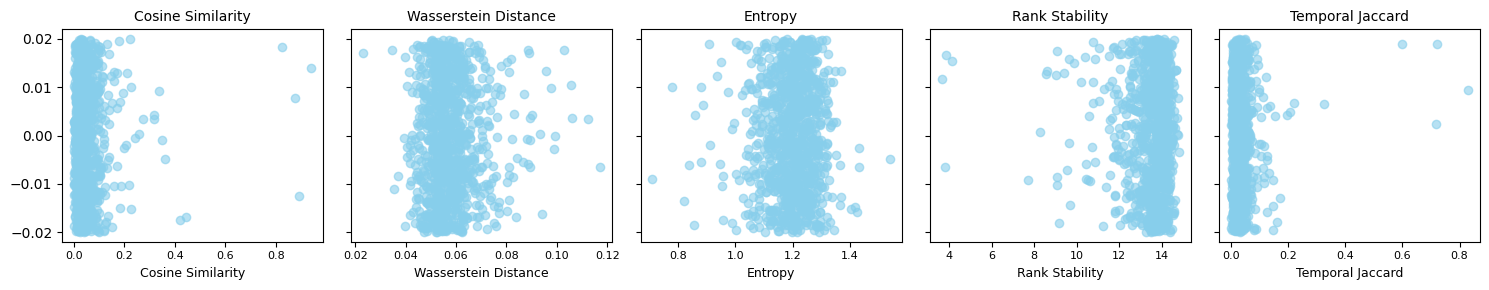

In [ ]:
# Extract only positive entropy words
pos_entropy_df = positive_entropy.copy()

# Set up subplots for scatterplots (5 in one row)
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 3), sharey=True)

for i, (metric, readable_name) in enumerate(metrics.items()):
    values = pos_entropy_df[metric].dropna()
    jitter = np.random.uniform(-0.02, 0.02, size=len(values))  # Add jitter to Y for visibility

    axes[i].scatter(values, jitter, alpha=0.6, color='skyblue')
    axes[i].set_xlabel(readable_name, fontsize=9)
    axes[i].set_title(readable_name, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return {row['Word']: row[column] for _, row in outliers.iterrows()}
outliers_dict = {metric: find_outliers(pos_entropy_df, metric) for metric in metrics.keys()}
outlier_sets = {metric: set(outliers.keys()) for metric, outliers in outliers_dict.items()}
all_outliers = [word for words in outlier_sets.values() for word in words]
word_counts = Counter(all_outliers)
repeated_outliers = {word: count for word, count in word_counts.items() if count > 1}

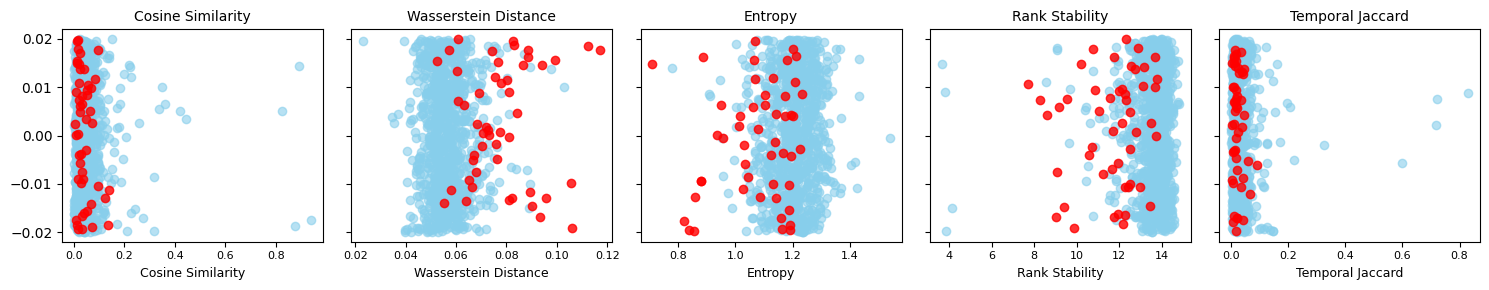

In [111]:
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 3), sharey=True)

for i, (metric, readable_name) in enumerate(metrics.items()):
    # Drop rows where the metric is NaN
    valid_data = pos_entropy_df[[metric, 'First_First_Guess_Guess']].dropna()
    
    # Extract values
    values = valid_data[metric]
    jitter = np.random.uniform(-0.02, 0.02, size=len(values))  # Jitter for visibility
    
    # Separate red and skyblue points
    is_red = valid_data['First_First_Guess_Guess'] == "</s>"
    
    # Plot skyblue points first (behind)
    axes[i].scatter(values[~is_red], jitter[~is_red], alpha=0.6, color='skyblue')
    
    # Plot red points on top
    axes[i].scatter(values[is_red], jitter[is_red], alpha=0.8, color='red')
    
    axes[i].set_xlabel(readable_name, fontsize=9)
    axes[i].set_title(readable_name, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [122]:
target_metrics = list(metrics.keys())

# Compute word frequencies
word_counts = pos_entropy_df["First_First_Guess_Guess"].value_counts()

# Filter words with at least 40 occurrences
valid_words = word_counts[word_counts >= 40].index

# Store results
results_list = []

for metric in target_metrics:
    # Full distribution of the entire dataset (excluding NaNs)
    full_distribution = pos_entropy_df[metric].dropna()

    for word in valid_words:  # Only use words with ≥40 instances
        # Extract values for the specific word
        word_values = pos_entropy_df[pos_entropy_df["First_First_Guess_Guess"] == word][metric].dropna()

        # Ensure we have enough data for statistical testing
        if len(word_values) < 5 or len(full_distribution) < 10:  # Require at least 5 word samples & a reasonable full set
            continue

        # KS Test
        ks_stat, ks_p = stats.ks_2samp(word_values, full_distribution)

        # Mann-Whitney U Test
        mw_stat, mw_p = stats.mannwhitneyu(word_values, full_distribution, alternative="two-sided")

        # Effect Size: Cohen’s d
        def cohens_d(x, y):
            return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / 2)

        d = cohens_d(word_values, full_distribution)

        # Function to format p-values for readability
        def format_p_value(p):
            return f"{p:.2e}" if p < 1e-5 else f"{p:.5f}"

        # Store results in a structured format
        results_list.append({
            "Metric": metric,
            "Word": word,
            "Word Count": len(word_values),
            "KS p-value": format_p_value(ks_p),
            "Mann-Whitney p-value": format_p_value(mw_p),
            "Cohen’s d": d
        })

# Convert to DataFrame
hotandfun = pd.DataFrame(results_list)

In [123]:
hotandfun

,Metric,Word,Word Count,KS p-value,Mann-Whitney p-value,Cohen’s d
0,First_Cosine_Similarity_Mean,people,96,6.50e-09,2.66e-07,0.088824
1,First_Cosine_Similarity_Mean,the,64,0.42216,0.54462,0.094165
2,First_Cosine_Similarity_Mean,</s>,49,0.51916,0.35794,-0.175425
3,First_Cosine_Similarity_Mean,it,45,0.44348,0.31441,-0.265395
4,First_Wasserstein_Distance_Mean,people,96,0.21623,0.69162,-0.176231
5,First_Wasserstein_Distance_Mean,the,64,0.04744,0.00816,-0.431488
6,First_Wasserstein_Distance_Mean,</s>,49,2.22e-21,8.13e-21,1.630139
7,First_Wasserstein_Distance_Mean,it,45,0.02791,0.00870,-0.463462
8,First_Entropy_Mean,people,96,0.00456,0.00323,-0.229058
9,First_Entropy_Mean,the,64,0.32520,0.12409,0.211404


In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [1]:
features = [
    "First_Cosine_Similarity_Mean", 
    "First_Rank_Stability_Mean", 
    "First_Temporal_Jaccard_Mean"
]

full_df = merged_df.copy()

full_df["Negative_Entropy_Label"] = (full_df['normalized_time_entropy_zscore'] < 0).astype(int)
df_clean = full_df.dropna(subset=features + ["Negative_Entropy_Label"])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[features], df_clean["Negative_Entropy_Label"], test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")

# Print detailed classification report
print(classification_report(y_test, y_pred))

feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

NameError: name 'merged_df' is not defined

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[features], df_clean["normalized_time_entropy_zscore"], test_size=0.2, random_state=42
)

# Train Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on test set
y_pred = rf_regressor.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_regressor.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

Mean Absolute Error (MAE): 0.3438
Mean Squared Error (MSE): 0.3128
Root Mean Squared Error (RMSE): 0.5593
R² Score: 0.0592
